# Day 27

Yesterday I made a heatmap of average score by season and week (regular season only) and noticed that scores from 1999-2010 might be lower than scores from 2011-2022. Because I have the scores from each game, I know the variance of each subgroup. It makes sense to **perform a two sample z-test** to test if the mean (average) score from the 1999-2010 regular season is **significantly smaller** than the mean score from the 2011-2022 regular season.

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from statsmodels.stats.weightstats import ztest as ztest

np.random.seed(2022)

# Create database connection
conn = sqlite3.connect('../../data/db/database.db')

Dataset is all games so far
Box plot of total number of field goals and win_margin
Use the box plot template from the practical exam

## Query Data

In [121]:
# query = """
# WITH pbp_summary AS (
#     WITH all_games AS (
#         SELECT DISTINCT game_id, season, week, season_type, posteam AS team
#         FROM pbp
#         WHERE team IS NOT NULL
#             AND team <> ''
#             --AND week <= 10
#         ORDER BY game_id),
#     offense AS (
#         SELECT
#         game_id,
#         posteam AS team,
#         SUM(pass_touchdown) AS tot_pass_tds,
#         SUM(rush_touchdown) AS tot_rush_tds
#         FROM pbp
#         WHERE team IS NOT NULL and team <> ''
#         GROUP BY game_id, team),
#     ret_tds AS (
#         SELECT 
#             game_id, 
#             td_team AS team,
#             SUM(return_touchdown) AS tot_ret_tds
#         FROM pbp
#         WHERE return_touchdown = 1 AND td_team = posteam
#         GROUP BY game_id, team), 
#     extra_pts AS (
#         SELECT
#             game_id,
#             posteam AS team,
#             COUNT(*) AS tot_extra_pts
#         FROM pbp
#         WHERE extra_point_attempt = 1 AND extra_point_result = 'good'
#         GROUP BY game_id, posteam),
#     field_goals AS (
#         SELECT 
#             game_id,
#             -- Correct for data error in game_id: 2000_11_OAK_DEN
#             CASE WHEN game_id = '2000_11_OAK_DEN' 
#                 AND desc LIKE '%J.Elam%' 
#                 AND desc LIKE '%field goal%' 
#                 THEN 'DEN'
#             ELSE posteam
#             END AS team,
#             COUNT(*) AS tot_fgs
#         FROM pbp
#         WHERE field_goal_attempt = 1 
#             AND field_goal_result = 'made'
#             AND desc LIKE '%field goal%'
#         GROUP BY game_id, team), 
#     two_pt_convs AS (
#         SELECT 
#             game_id,
#             posteam AS team,
#             COUNT(*) AS tot_2pt_conv
#         FROM pbp
#         WHERE two_point_attempt = 1 AND two_point_conv_result = 'success'
#         GROUP BY game_id, posteam),
#     -- Counts defensive TDs and punt/kickoff return TDs
#     defense AS (
#         SELECT
#             game_id,
#             td_team AS team,
#             COUNT(*) AS tot_def_tds
#         FROM pbp
#         WHERE touchdown = 1
#             AND (
#                 defteam_score_post <> defteam_score
#                 OR (defteam_score IS NULL AND defteam_score_post >= 6)
#             )
#         GROUP BY game_id, td_team),
#     safeties AS (
#         SELECT
#             game_id,
#             CASE WHEN defteam_score_post <> defteam_score THEN defteam
#             ELSE posteam
#             END AS team,
#             COUNT(*) AS tot_safeties
#         FROM pbp
#         WHERE safety = 1
#         GROUP BY game_id, team),
#     def_2pt_att AS (
#         SELECT
#             game_id,
#             defteam AS team,
#             COUNT(*) AS tot_def_2pt
#         FROM pbp
#         WHERE desc LIKE '%DEFENSIVE TWO-POINT ATTEMPT%'
#             AND defteam_score_post <> defteam_score
#         GROUP BY game_id, team),
#     off_fumb_recovery AS (
#         SELECT
#             game_id,
#             posteam AS team,
#             COUNT(*) AS tot_off_fumble_recov_td
#         FROM pbp
#         WHERE desc LIKE '%fumble%'
#             AND posteam_score_post <> posteam_score
#             AND touchdown = 1
#             AND pass_touchdown = 0
#             AND rush_touchdown = 0
#             AND return_touchdown = 0
#         GROUP BY game_id, team),
#     joined AS (
#         SELECT 
#             all_games.*,
#             -- offense.*,
#             CASE WHEN tot_pass_tds IS NULL THEN 0
#             ELSE tot_pass_tds
#             END AS tot_pass_tds,
#             CASE WHEN tot_rush_tds IS NULL THEN 0
#             ELSE tot_rush_tds
#             END AS tot_rush_tds,
#             CASE WHEN tot_ret_tds IS NULL THEN 0
#             ELSE tot_ret_tds
#             END AS tot_ret_tds,
#             CASE WHEN tot_extra_pts IS NULL THEN 0
#             ELSE tot_extra_pts
#             END AS tot_extra_pts,
#             CASE WHEN tot_fgs IS NULL THEN 0
#             ELSE tot_fgs
#             END AS tot_fgs,
#             CASE WHEN tot_2pt_conv IS NULL THEN 0
#             ELSE tot_2pt_conv
#             END AS tot_2pt_conv,
#             CASE WHEN tot_def_tds IS NULL THEN 0
#             ELSE tot_def_tds
#             END AS tot_def_tds,
#             CASE WHEN tot_safeties IS NULL THEN 0
#             ELSE tot_safeties
#             END AS tot_safeties,
#             CASE WHEN tot_def_2pt IS NULL THEN 0
#             ELSE tot_def_2pt
#             END AS tot_def_2pt,
#             CASE WHEN tot_off_fumble_recov_td IS NULL THEN 0
#             ELSE tot_off_fumble_recov_td
#             END AS tot_off_fumble_recov_td
#         FROM all_games
#         LEFT JOIN offense
#             ON offense.game_id = all_games.game_id
#                 AND offense.team = all_games.team
#         LEFT JOIN ret_tds
#             ON ret_tds.game_id = all_games.game_id
#                 AND ret_tds.team = all_games.team  
#         LEFT JOIN extra_pts
#             ON extra_pts.game_id = all_games.game_id
#                 AND extra_pts.team = all_games.team
#         LEFT JOIN field_goals
#             ON field_goals.game_id = all_games.game_id
#                 AND field_goals.team = all_games.team
#         LEFT JOIN two_pt_convs
#             ON two_pt_convs.game_id = all_games.game_id
#                 AND two_pt_convs.team = all_games.team
#         LEFT JOIN defense
#             ON defense.game_id = all_games.game_id
#                 AND defense.team = all_games.team
#         LEFT JOIN safeties
#             ON safeties.game_id = all_games.game_id
#                 AND safeties.team = all_games.team
#         LEFT JOIN def_2pt_att
#             ON def_2pt_att.game_id = all_games.game_id
#                 AND def_2pt_att.team = all_games.team
#         LEFT JOIN off_fumb_recovery
#             ON off_fumb_recovery.game_id = all_games.game_id
#                 AND off_fumb_recovery.team = all_games.team
#     )
#     SELECT *,
#         (tot_pass_tds * 6
#         + tot_rush_tds * 6
#         + tot_ret_tds * 6
#         + tot_extra_pts * 1
#         + tot_fgs * 3
#         + tot_2pt_conv * 2
#         + tot_def_tds * 6
#         + tot_safeties * 2
#         + tot_def_2pt * 2
#         + tot_off_fumble_recov_td * 6) AS score,
#         -- Use old team abbrev. that matches game_id for teams that moved (pbp data has new names)
#         CASE
#             WHEN game_id LIKE '%OAK%' AND team = 'LV' THEN 'OAK'
#             WHEN game_id LIKE '%SD%' AND team = 'LAC' THEN 'SD'
#             WHEN game_id LIKE '%STL%' AND team = 'LA' THEN 'STL'
#             ELSE team
#         END AS team_fixed
#     FROM joined
# ), sched AS (
#     WITH sched_historical AS (
#         WITH home_games AS (
#             SELECT
#                 game_id,
#                 season,
#                 week,
#                 game_type,
#                 home_team AS team,
#                 home_score AS score
#             FROM schedules
#             WHERE season < 2022
#         ), away_games AS (
#             SELECT
#                 game_id,
#                 season,
#                 week,
#                 game_type,
#                 away_team AS team,
#                 away_score AS score
#             FROM schedules
#             WHERE season < 2022
#         )
#         -- Stack the data
#         SELECT *
#         FROM home_games
#         UNION ALL
#         SELECT *
#         FROM away_games
#     ), sched_2022 AS (
#         WITH home_games AS (
#             SELECT
#                 game_id,
#                 season,
#                 week,
#                 game_type,
#                 home_team AS team,
#                 home_score AS score
#             FROM schedules
#             WHERE season = 2022 AND week <= 10
#         ), away_games AS (
#             SELECT
#                 game_id,
#                 season,
#                 week,
#                 game_type,
#                 away_team AS team,
#                 away_score AS score
#             FROM schedules
#             WHERE season = 2022 AND week <= 10
#         )
#         SELECT *
#         FROM home_games
#         UNION ALL
#         SELECT *
#         FROM away_games
#     )
#     SELECT *
#     FROM sched_historical
#     UNION ALL
#     SELECT *
#     FROM sched_2022
# )
# SELECT
#     sched.game_id,
#     sched.team,
#     sched.score AS sched_score,
#     pbp_summary.score AS pbp_score,
#     (sched.score - pbp_summary.score) AS score_diff,
#     tot_pass_tds,
#     tot_rush_tds,
#     tot_ret_tds,
#     tot_extra_pts,
#     tot_fgs,
#     tot_2pt_conv,
#     tot_def_tds,
#     tot_safeties,
#     tot_def_2pt,
#     tot_off_fumble_recov_td
# FROM sched
# LEFT JOIN pbp_summary
#     ON pbp_summary.game_id = sched.game_id
#     AND pbp_summary.team_fixed = sched.team
# WHERE pbp_score IS NOT NULL
# """

query = """
SELECT *
FROM pbp_score_summary
WHERE pbp_score IS NOT NULL
"""

df_pbp = pd.read_sql(query, conn)
print(len(df_pbp))
df_pbp.head()

12568


,game_id,team,sched_score,pbp_score,score_diff,tot_pass_tds,tot_rush_tds,tot_ret_tds,tot_extra_pts,tot_fgs,tot_2pt_conv,tot_def_tds,tot_safeties,tot_def_2pt,tot_off_fumble_recov_td
0,1999_01_MIN_ATL,ATL,14.0,14.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1999_01_KC_CHI,CHI,20.0,20.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
2,1999_01_PIT_CLE,CLE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1999_01_OAK_GB,GB,28.0,28.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1999_01_BUF_IND,IND,31.0,31.0,0.0,2.0,1.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0


In [122]:
query = """
WITH data AS (
    SELECT
        game_id,
        season,
        week,
        ABS(result) AS win_margin
    FROM schedules 
    WHERE game_type = 'REG' AND (
        season <= 2021 OR season = 2022 AND week <= 10
    )
)
SELECT *
FROM data
"""

df_win_margin = pd.read_sql(query, conn)
print(len(df_win_margin))
df_win_margin.head()

6030


,game_id,season,week,win_margin
0,1999_01_MIN_ATL,1999,1,3.0
1,1999_01_KC_CHI,1999,1,3.0
2,1999_01_PIT_CLE,1999,1,43.0
3,1999_01_OAK_GB,1999,1,4.0
4,1999_01_BUF_IND,1999,1,17.0


In [123]:
df_win_margin.head()

,game_id,season,week,win_margin
0,1999_01_MIN_ATL,1999,1,3.0
1,1999_01_KC_CHI,1999,1,3.0
2,1999_01_PIT_CLE,1999,1,43.0
3,1999_01_OAK_GB,1999,1,4.0
4,1999_01_BUF_IND,1999,1,17.0


The win margin data is at the game level but the play-by-play summary is at the game-team level. I'll need to aggregate before joining

In [124]:
# Aggregate and sum the columns (want to see totals)
df_pbp_by_game = df_pbp.groupby('game_id').sum().reset_index()
df_pbp_by_game

/var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/ipykernel_75444/2268746976.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pbp_by_game = df_pbp.groupby('game_id').sum().reset_index()


,game_id,sched_score,pbp_score,score_diff,tot_pass_tds,tot_rush_tds,tot_ret_tds,tot_extra_pts,tot_fgs,tot_2pt_conv,tot_def_tds,tot_safeties,tot_def_2pt,tot_off_fumble_recov_td
0,1999_01_ARI_PHI,49.0,49.0,0.0,3.0,2.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0
1,1999_01_BUF_IND,45.0,45.0,0.0,3.0,1.0,0.0,4.0,3.0,1.0,1.0,0.0,0.0,0.0
2,1999_01_CAR_NO,29.0,29.0,0.0,2.0,0.0,0.0,2.0,3.0,0.0,1.0,0.0,0.0,0.0
3,1999_01_CIN_TEN,71.0,71.0,0.0,5.0,3.0,0.0,5.0,4.0,2.0,0.0,1.0,0.0,0.0
4,1999_01_DAL_WAS,76.0,76.0,0.0,7.0,3.0,0.0,8.0,2.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6279,2022_10_LAC_SF,38.0,38.0,0.0,1.0,2.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0
6280,2022_10_MIN_BUF,63.0,63.0,0.0,2.0,4.0,0.0,6.0,5.0,0.0,1.0,0.0,0.0,0.0
6281,2022_10_NO_PIT,30.0,30.0,0.0,1.0,2.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0
6282,2022_10_SEA_TB,37.0,37.0,0.0,4.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0


There are 3 less records in `df_pbp_by_game` because there are 3 missing games in the play-by-play data.

In [125]:
merged = pd.merge(df_pbp_by_game,
                  df_win_margin,
                  how='left',
                  on='game_id')

merged

,game_id,sched_score,pbp_score,score_diff,tot_pass_tds,tot_rush_tds,tot_ret_tds,tot_extra_pts,tot_fgs,tot_2pt_conv,tot_def_tds,tot_safeties,tot_def_2pt,tot_off_fumble_recov_td,season,week,win_margin
0,1999_01_ARI_PHI,49.0,49.0,0.0,3.0,2.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,1999.0,1.0,1.0
1,1999_01_BUF_IND,45.0,45.0,0.0,3.0,1.0,0.0,4.0,3.0,1.0,1.0,0.0,0.0,0.0,1999.0,1.0,17.0
2,1999_01_CAR_NO,29.0,29.0,0.0,2.0,0.0,0.0,2.0,3.0,0.0,1.0,0.0,0.0,0.0,1999.0,1.0,9.0
3,1999_01_CIN_TEN,71.0,71.0,0.0,5.0,3.0,0.0,5.0,4.0,2.0,0.0,1.0,0.0,0.0,1999.0,1.0,1.0
4,1999_01_DAL_WAS,76.0,76.0,0.0,7.0,3.0,0.0,8.0,2.0,1.0,0.0,0.0,0.0,0.0,1999.0,1.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6279,2022_10_LAC_SF,38.0,38.0,0.0,1.0,2.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,2022.0,10.0,6.0
6280,2022_10_MIN_BUF,63.0,63.0,0.0,2.0,4.0,0.0,6.0,5.0,0.0,1.0,0.0,0.0,0.0,2022.0,10.0,3.0
6281,2022_10_NO_PIT,30.0,30.0,0.0,1.0,2.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,2022.0,10.0,10.0
6282,2022_10_SEA_TB,37.0,37.0,0.0,4.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,2022.0,10.0,5.0


## Exploration

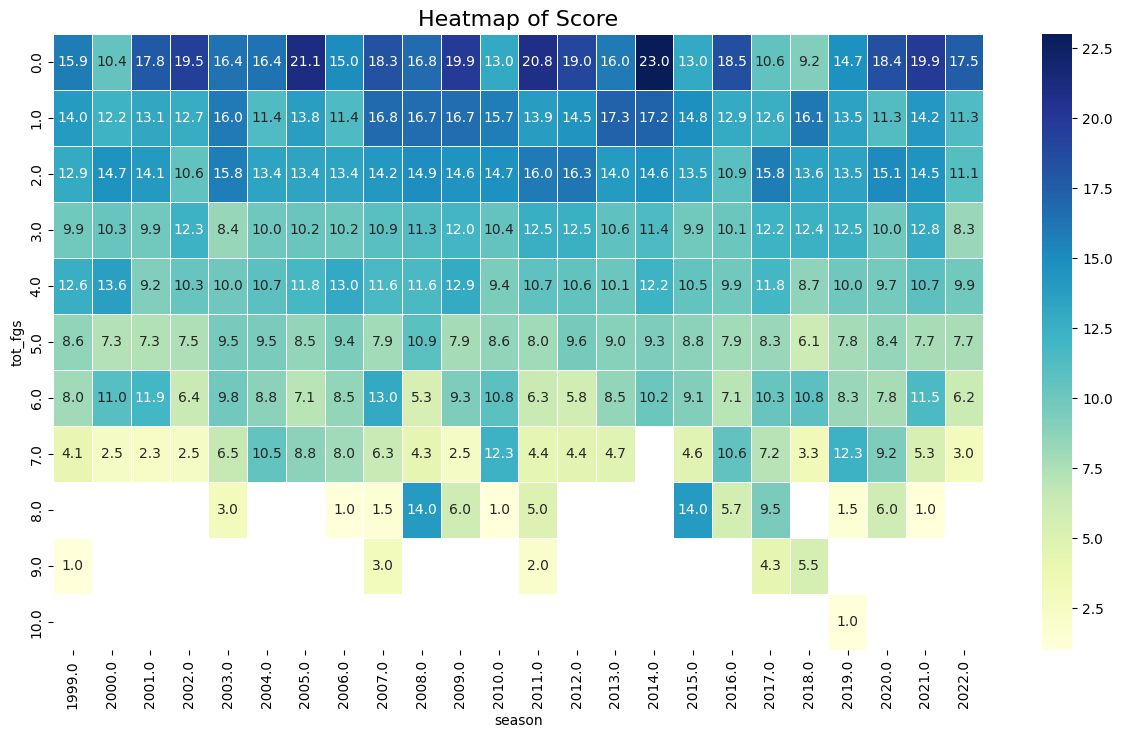

In [126]:
# Define crosstab
crosstab = pd.crosstab(merged['tot_fgs'],
                        merged['season'],
                        values=merged['win_margin'],
                        dropna=True,
                        aggfunc='mean')

# Plot Heatmap
plt.figure(figsize = (15,8))

g = sns.heatmap(
    crosstab,
    annot=True,
    fmt='.1f',
    cmap="YlGnBu",
    cbar=True,
    linewidth=.5
)

g.set_title(f"Heatmap of Score", size=16)

plt.show()

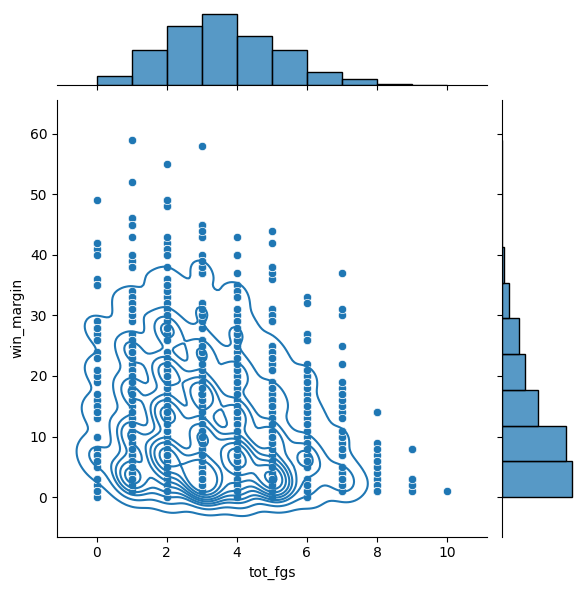

<Figure size 640x480 with 0 Axes>

In [127]:
g = sns.jointplot(x="tot_fgs",
					y="win_margin",
					kind='scatter',
					data=merged,
					marginal_kws=dict(bins=10))
g.plot_joint(sns.kdeplot)

plt.show()
plt.clf()

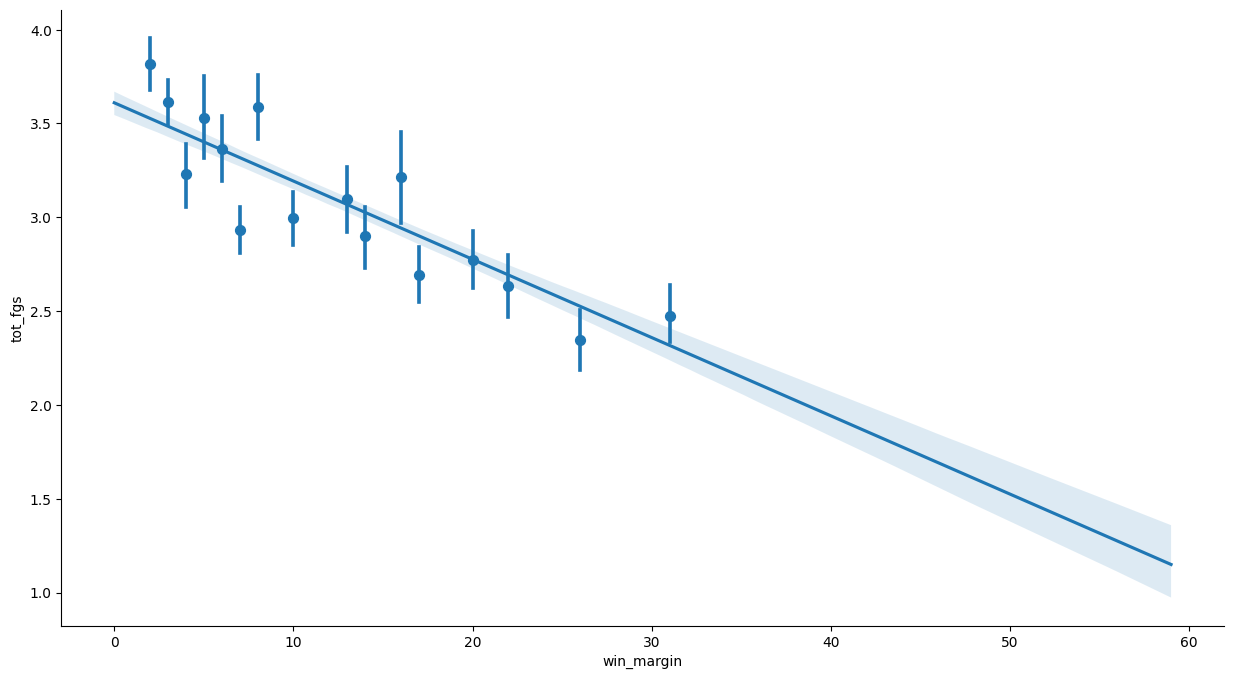

In [142]:
# Change plot size
plt.figure(figsize = (15,8))

sns.regplot(
    data=merged,
    x='win_margin',
    y='tot_fgs',
    # x_estimator=np.mean
    # x_bins=20
)

# Add labels and title
g.set_xlabel("Total Field Goals Made", size=12)
g.set_ylabel("Game margin of Victory", size=12)
g.set_title("Total Field Goals / gm and Margin of Victory", size=16)

sns.despine()
plt.show()

In [141]:
merged['tot_fgs'].corr(merged['win_margin'])

-0.23976887733546584

There looks to be a weak negative linear relationship between the number of field goals made in a game and margin of victory. 

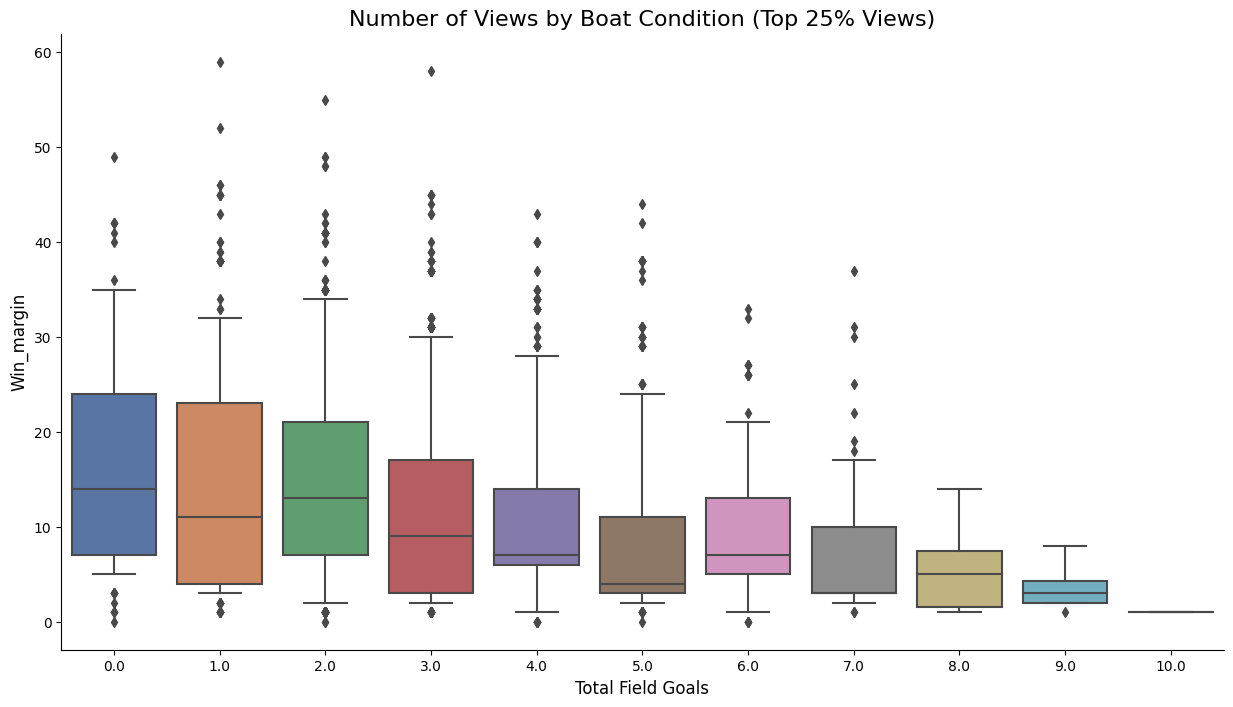

In [130]:
# Change plot size
plt.figure(figsize = (15,8))

# Plot
g = sns.boxplot(
    x='tot_fgs',
    y='win_margin',
    data=merged,
    palette='deep',
    whis=[5,95],
    orient='v'
)

# Add labels and title
g.set_xlabel("Total Field Goals", size=12)
g.set_ylabel("Win_margin", size=12)
g.set_title("Number of Views by Boat Condition (Top 25% Views)", size=16)

# Customize x-axis
# g.set_xscale('log')                                                       # log scale due large range of values
# g.set_xticks([25, 50, 100, 250, 500, 1000, 2500])                       # customize ticks -- all data
# g.set_xticks([175, 250, 500, 750, 1000, 1500, 2500, 3500, 5000])          # customize ticks -- top 25% of views

# g.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  # remove scientific notation after forcing log scale

# g.get_xaxis().set_tick_params(which='minor', size=0)    # make minor ticks invisible
# g.get_xaxis().set_tick_params(which='minor', width=0)   # make minor ticks invisible

# g.xaxis.grid(True)      # show vertical gridlines
sns.despine()           # remove spines for a cleaner look
# g.set_axisbelow(True)   # gridlines behind other graph elements

<AxesSubplot: xlabel='tot_fgs', ylabel='Count'>

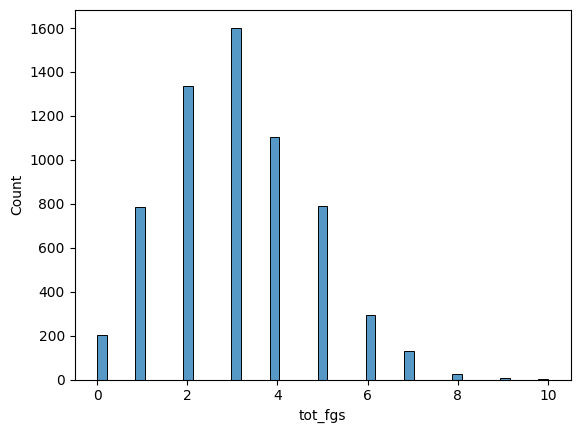

In [131]:
sns.histplot(merged['tot_fgs'])

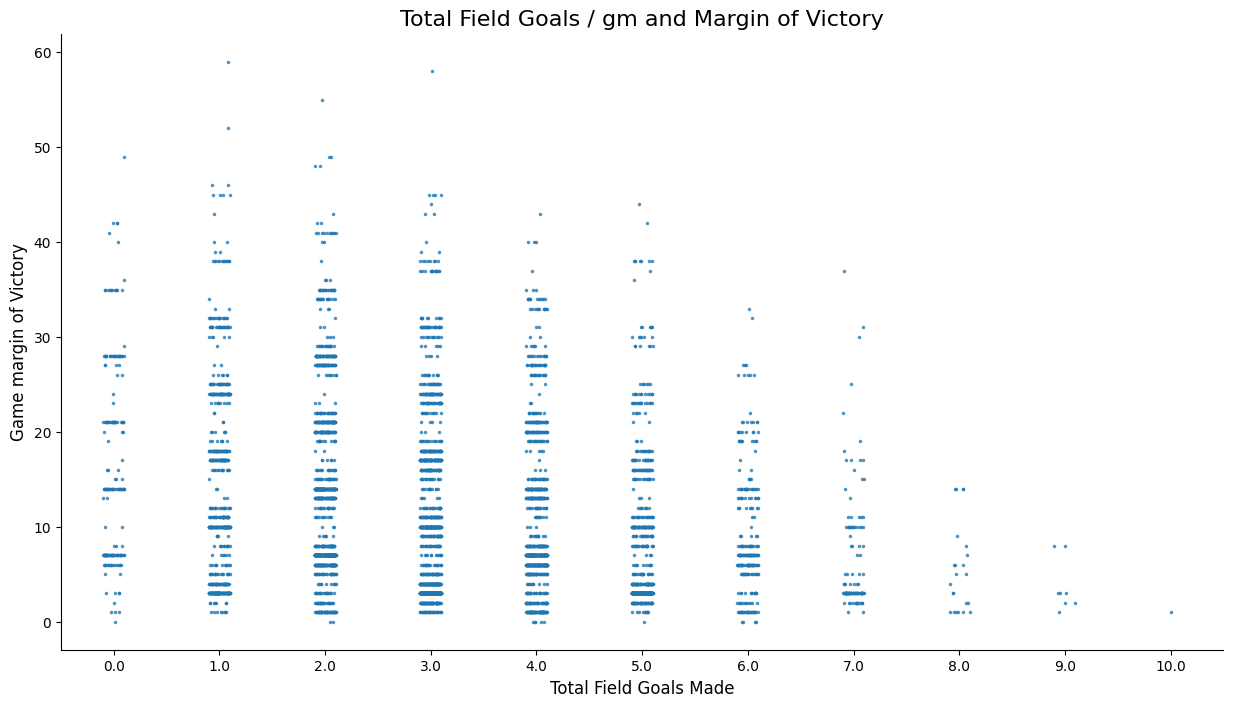

In [150]:
# Change plot size
plt.figure(figsize = (15,8))

g = sns.stripplot(
    x='tot_fgs',
    y='win_margin',
    data=merged,
    jitter=True,
    size=2.5,
    alpha=0.8,
    # palette='deep',
    # whis=[5,95],
    # orient='v'
)

# Add labels and title
g.set_xlabel("Total Field Goals Made", size=12)
g.set_ylabel("Game margin of Victory", size=12)
g.set_title("Total Field Goals / gm and Margin of Victory", size=16)

sns.despine()
plt.show()

In [143]:
merged['tot_fgs'].corr(merged['win_margin'])

-0.23976887733546584

There is a weak negative linear relationship between total field goals in a game and the game's margin of victory. This makes sense. Games with a high number of fields goals made are by definition games where at least one team's offense isn't clicking well – likely getting stopped and needed to settle for FGs.